In [0]:
# parcially taken from https://github.com/GunhoChoi/AnoGAN-Pytorch

In [0]:
!pip install comet-ml

     |████████████████████████████████| 174kB 3.5MB/s 
     |████████████████████████████████| 409kB 11.1MB/s 
     |████████████████████████████████| 204kB 10.7MB/s 
  Created wheel for configobj: filename=configobj-5.0.6-cp36-none-any.whl size=34546 sha256=d229e73e12f1f5d0fa48a3dbe35d404a8e4bfe00441da8372fade3289eb10141
  Stored in directory: /root/.cache/pip/wheels/f1/e4/16/4981ca97c2d65106b49861e0b35e2660695be7219a2d351ee0
Successfully built configobj


In [0]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" # set gpu number to use


from comet_ml import Experiment
import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
from torch.autograd import Variable
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

%matplotlib inline
from IPython.display import clear_output
import random
import itertools

# Постановка задачи

Задача поиска аномалий - находить объекты, отличные от нормальных данных

**Примеры:** поиск сбоев, атак, ботов и другого аномального поведения или объектов

Как правило, ***основное отличие задачи поиска аномалий от задачи бинарной классификации*** заключается в том, что ***аномалий*** в выборке ***намного меньше или нет вообще***!

В связи с этим, большинство алгоритмов поиска аномалий, таких как OneClass-SVM и Isolation Forest, основываются на ***гипотезе о компактности***, когда нормальные объекты образуют некоторый кластер или группу кластеров (см. рис. ниже), а аномалии выходят за пределы этих кластеров
![](https://developer.mindsphere.io/apis/analytics-anomalydetection/images/DBSCAN.png)


Для экспериментов будем использовать датасет рукописных цифр MNIST

In [0]:
anomaly_digit = 0 # какую цифру примем за аномалию

In [0]:
# Зададим обучающую и тестовую выборки в PyTorch

def sample_noise(batch_size, dim):
    normal = torch.distributions.Normal(loc=0, scale=1)
    return normal.sample((batch_size, dim))

def shuffle(a,b):
    assert len(a) == len(b)
    start_state = random.getstate()
    random.shuffle(a)
    random.setstate(start_state)
    random.shuffle(b)

def fixed_anomaly_loader(anomaly_num, is_train=True, batch_size=256):
    mnist_train0 = dset.MNIST("./", train=is_train, 
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5]),
                            ]),
                            target_transform=None,
                            download=True)
    
    idx = mnist_train0.targets==anomaly_digit
    anomaly_num = min(anomaly_num, idx.sum().item())
    mnist_train0.targets = mnist_train0.targets[idx]
    mnist_train0.data = mnist_train0.data[idx]

    el = len((mnist_train0.targets))
    shuffle(mnist_train0.targets, mnist_train0.data)
    mnist_train0.targets = mnist_train0.targets[[True] * anomaly_num + [False] * (el - anomaly_num)]
    mnist_train0.data = mnist_train0.data[[True] * anomaly_num + [False] * (el - anomaly_num)]


    mnist_train1 = dset.MNIST("./", train=is_train, 
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5]),
                            ]),
                            target_transform=None,
                            download=True)

    idx = mnist_train1.targets!=anomaly_digit
    mnist_train1.targets = mnist_train1.targets[idx]
    mnist_train1.data = mnist_train1.data[idx]

    ds = torch.utils.data.ConcatDataset([mnist_train0, mnist_train1])

    loader = torch.utils.data.DataLoader(dataset=ds, batch_size=batch_size,shuffle=True)
    # DataLoader - вспомогательный класс PyTorch, который разбивает данные на батчи
    return loader

# Baseline
В качестве бейслайна попробуем обучить бинарный классификатор (аномалия/не аномалия) в условиях малого количества аномалий

## Задание 1
Обучите бинарный классификатор для поиска аномалий. Посмотрите на финальный ROC AUC 

In [0]:
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
from tqdm import tqdm_notebook

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

api = 'GGF21Vtrnid3Cgat9n1nL9Vcc'
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=7, padding=3),
            nn.BatchNorm2d(16),
            #nn.MaxPool2d(kernel_size=2),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(16, 32, kernel_size=7, padding=3),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2), # 128 x 7 x 7
            nn.LeakyReLU(),
            nn.Dropout(0.1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
model = AlexNet(num_classes=1)
model.to(device)
num_classes=1
criterion = nn.BCEWithLogitsLoss() # бинарная кросс-энтропия 
opt = torch.optim.Adam(model.parameters(), lr=0.05) # оптимизатор

num_anomalies = 50 # количество используемых аномалий. В обучении не должно использоваться больше указанного числа!
epoch = 25 # сколько циклов обучения (сколько раз прогоним всю обучаюшую выборку в процессе обучения)

In [0]:
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=1):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, padding=1),
        )
        self.classifier = nn.Sequential(
            nn.Linear(4*4*32, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [0]:
torch.cuda.empty_cache()

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/comet-ml-testing/roc-auc-mnist/14faa1c63bd54d0881d4835a07d00670

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 21324718.21it/s]                            


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


32768it [00:00, 329956.96it/s]
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


1654784it [00:00, 5719124.97it/s]                           
8192it [00:00, 133547.90it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw
Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!



Epoch: 24	 Loss: 8.365784742636606e-05 ROC AUC: 0.9999277161862529



Epoch: 24	 Loss: 0.000292797019938007 ROC AUC: 0.9999364966740578



Epoch: 24	 Loss: 4.203552089165896e-05 ROC AUC: 0.9999952993348116



Epoch: 24	 Loss: 0.0003624880046118051 ROC AUC: 0.9999971618625277



Epoch: 24	 Loss: 3.3473574148956686e-05 ROC AUC: 0.999995397981809



Epoch: 24	 Loss: 9.934106870446158e-09 ROC AUC: 0.999996239648853


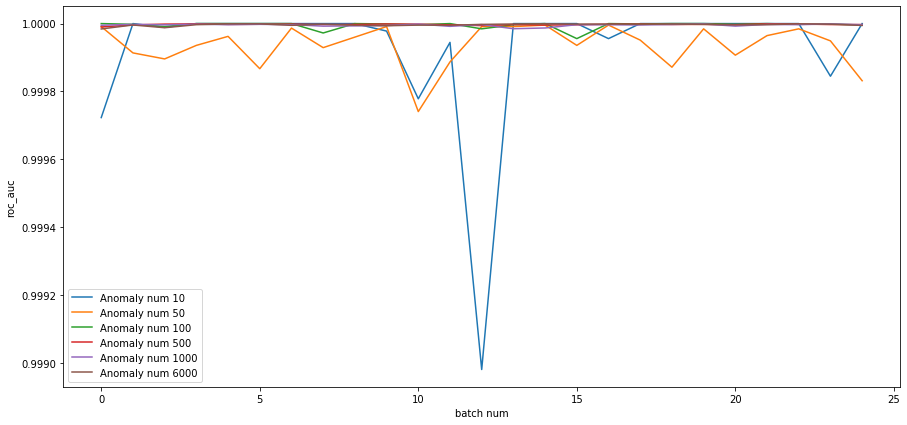

In [0]:
plt.figure(figsize=(15,7))
experiment = Experiment(api_key=api, project_name="roc_auc mnist", workspace="comet-ml testing")
for anomaly_num in [10, 50, 100, 500, 1000, 6000]:
    experiment.log_metric("anomalies amount", anomaly_num)
    train_loader = fixed_anomaly_loader(anomaly_num * 6)
    test_loader = fixed_anomaly_loader(anomaly_num, False, 512)
    roc_aucs = []
    for i in tqdm_notebook(range(epoch)):
        model.train()
        for j,(image,label) in enumerate(train_loader):
            image = image.to(device)
            label = label.view(len(label), 1).float()
            label = label.to(device)
            predict = model(image)
            loss = criterion(predict, (label != anomaly_digit).float())
            experiment.log_metric("bin cross entropy loss", loss.cpu().detach().numpy())
            loss.backward()
            opt.step()
            opt.zero_grad()  
        model.eval()
        roc_auc = 0 
        predictions, labels = np.array([]), np.array([])
        for j,(image,label) in enumerate(test_loader):
            predict = model(image.to(device))
            if predictions.size == 0:
                predictions = predict.view(predict.shape[0]).cpu().detach().numpy()
                labels = label
            else:
                predictions = np.hstack((predictions, predict.view(predict.shape[0]).cpu().detach().numpy()))
                labels = np.hstack((labels, label))
        roc_auc = roc_auc_score((labels != anomaly_digit).astype(int), predictions)
        experiment.log_metric("roc auc", roc_auc)
        roc_aucs.append(roc_auc)
    print(f'Epoch: {i}\t Loss: {loss.item()} ROC AUC: {np.array(roc_aucs).mean()}')
    plt.plot(roc_aucs, label="Anomaly num {}".format(anomaly_num))
    plt.xlabel("batch num")
    plt.ylabel("roc_auc")
plt.legend()

# AnoGAN

Основная идея [AnoGAN](https://arxiv.org/abs/1703.05921) - находить аномалии на основе расстояния до ближайшего соседа в пространстве латентных переменных. Алгоритм состоит из двух этапов:
1. На первом этапе обучается дискриминатор и генератор в стандартном режиме на нормальных объектах. При этом предполается, что генератор выучивает некоторое преобразование из латентного многообразия Z в пространство нормальных объектов
2. На втором этапе для каждого нового объекта считается расстояние до латентного многообразия, в котором сконцентрированы нормальные объекты. Те объекты, расстояние от которых до многообразия слишком большое, принимаются за аномалии

![](https://i.ibb.co/ZmzwMfS/image.png)

# AnoGAN. Этап 1. Обучение генератора на нормальных объектах

In [0]:
# Generator receives random noise z and create 1x28x28 image
# we can name each layer using OrderedDict

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(
             nn.Linear(100,7*7*512),
             nn.BatchNorm1d(7*7*512),
             nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(512,256,3,2,1,1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(256,128,3,1,1),
                        nn.BatchNorm2d(128),    
                        nn.LeakyReLU(),
            )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.BatchNorm2d(64),    
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(64,1,3,2,1,1),
                        nn.Tanh()
            )

    def forward(self,z):
        out = self.layer1(z)
        out = out.view(out.size()[0],512,7,7)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [0]:
# Discriminator receives 1x28x28 image and returns a float number 0~1
# we can name each layer using OrderedDict

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,8,3,padding=1),   # batch x 16 x 28 x 28
                        nn.BatchNorm2d(8),    
                        nn.LeakyReLU(),
                        nn.Conv2d(8,16,3,stride=2,padding=1),  # batch x 32 x 28 x 28
                        nn.BatchNorm2d(16),    
                        nn.LeakyReLU(),
                        #('max1',nn.MaxPool2d(2,2))   # batch x 32 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(16,32,3,stride=2,padding=1),  # batch x 64 x 14 x 14
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(),
                        #nn.MaxPool2d(2,2),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 128 x 7 x 7
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU()
        )
        self.fc = nn.Sequential(
                        nn.Linear(64*7*7,1)      
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size()[0], -1)
        feature = out
        out = self.fc(out)
        return out,feature

In [0]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

gen_opt = torch.optim.Adam(generator.parameters(), lr= 1e-3)
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=1e-3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_n_test(epochs, lmbd=10):
    BATCH_SIZE = 256
    train_loader = fixed_anomaly_loader(0)
    experiment = Experiment(api_key=api, project_name="mnist GAN", workspace="comet-ml testing")
    with experiment.train():
        for epoch in tqdm_notebook(range(epochs)):
            for i in tqdm_notebook(range(150)):
                '''
                for p in discriminator.parameters():
                    p.requires_grad = True
                '''
                for _ in range(2):
                    disc_opt.zero_grad()
                    noise = sample_noise(BATCH_SIZE, 100)
                    gen_data = generator(noise.to(device))
                    real_data, _ = next(iter(train_loader))
                    real_data = real_data.to(device)
                    t = torch.rand(BATCH_SIZE, 1, 1, 1).to(device)
                    t = t.expand(gen_data.size())
                    in_between = t * real_data.to(device)+ (1 - t) * gen_data.to(device)
                    in_between = torch.autograd.Variable(in_between, requires_grad=True)
                    disc_in_between, _ = discriminator(in_between)
                    gradients = torch.autograd.grad(outputs=disc_in_between, inputs=in_between,
                                      grad_outputs=torch.ones(disc_in_between.data.size()).to(device),
                                      create_graph=True, retain_graph=True, only_inputs=True)[0]
                    disc_fake, _ = discriminator(gen_data)
                    disc_real, _ = discriminator(real_data)

                    disc_loss = disc_fake.mean() - disc_real.mean() + ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lmbd

                    experiment.log_metric("discriminator loss", disc_loss.cpu().detach().numpy())
                    disc_loss.backward()
                    disc_opt.step()
                     
                ''' 
                for p in discriminator.parameters():
                    p.requires_grad = False
                '''
                for _ in range(3):
                    gen_opt.zero_grad() 

                    noise = sample_noise(BATCH_SIZE, 100).to(device)
                    gen_data = generator(noise)
                    if (i % 10) == 0:
                        plt.figure(figsize = (15,10))
                        plt.imshow(v_utils.make_grid(gen_data.data[:32]).cpu().detach().numpy()[0, :, :])
                        experiment.log_figure()
                        plt.close('all')
                    disc, _ = discriminator(gen_data)
                    gen_loss = -disc.mean()
                    experiment.log_metric("genetator loss", gen_loss.cpu().detach().numpy())
                    gen_loss.backward()
                    gen_opt.step() 
        experiment.end() 

In [0]:
def yet_another_iteration(k=5):
    train_n_test(k)
    noise = sample_noise(256, 100).to(device)
    gen_data = generator(noise)
    plt.figure(figsize = (15,10))
    plt.imshow(v_utils.make_grid(gen_data.data[:32]).cpu().detach().numpy()[0, :, :])

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/comet-ml-testing/roc-auc-mnist/14faa1c63bd54d0881d4835a07d00670
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     anomalies amount [6]          : (10.0, 6000.0)
COMET INFO:     bin cross entropy loss [33300]: (0.0, 0.749735951423645)
COMET INFO:     loss [3330]                   : (0.0, 0.749735951423645)
COMET INFO:     roc auc [150]                 : (0.998980044345898, 1.0)
COMET INFO:     sys.cpu.percent.01 [30]       : (31.6, 92.5)
COMET INFO:     sys.cpu.percent.02 [30]       : (4.8, 57.2)
COMET INFO:     sys.cpu.percent.avg [30]      : (18.2, 51.95)
COMET INFO:     sys.gpu.0.free_memory [33]    : (12970754048.0, 14956756992.0)
COMET INFO:     sys.gpu.0.gpu_utilization [33]: (0.0, 79.0)
COMET INFO:     sys.gpu.0.total_memory        : (15812263936.0, 15812263936.0)
COMET INFO:     sys.gpu.0.used_memory [33]    : (855506944.0, 28415

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/comet-ml-testing/mnist-gan/0727b118f92f4e07a3d6cf3f1cded0ac
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.cpu.percent.01                  : (81.0, 81.0)
COMET INFO:     sys.cpu.percent.02                  : (10.8, 10.8)
COMET INFO:     sys.cpu.percent.avg                 : (45.9, 45.9)
COMET INFO:     sys.gpu.0.free_memory               : (12970754048.0, 12970754048.0)
COMET INFO:     sys.gpu.0.gpu_utilization           : (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory              : (15812263936.0, 15812263936.0)
COMET INFO:     sys.gpu.0.used_memory               : (2841509888.0, 2841509888.0)
COMET INFO:     sys.ram.total                       : (13655232512.0, 13655232512.0)
COMET INFO:     sys.ram.used                        : (3608440832.0, 3608440832.0)
COMET INFO:     train_discriminator loss [2100]     : (-447.7054443

COMET INFO: Uploading stats to Comet before program termination (may take several seconds)


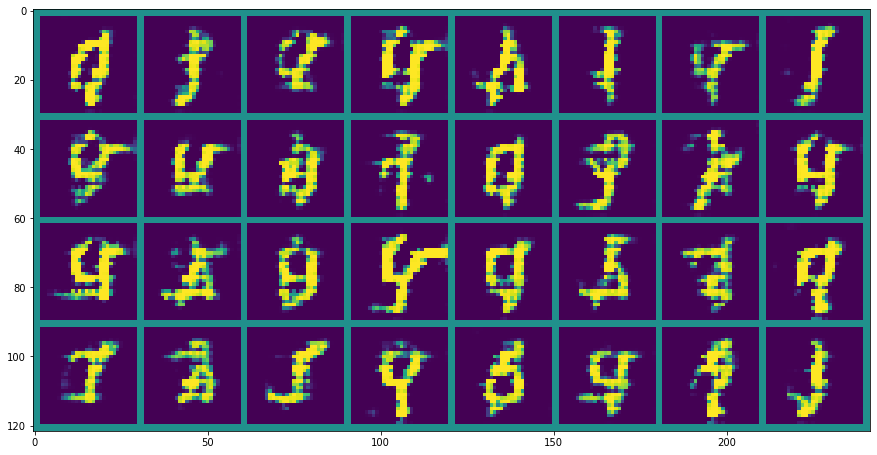

In [0]:
yet_another_iteration(7)

Then the model learned for 20 more iterations

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/comet-ml-testing/mnist-gan/f6c434c4ce3b4b56bff34aa9fb064899



COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/comet-ml-testing/mnist-gan/f6c434c4ce3b4b56bff34aa9fb064899
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.cpu.percent.01                  : (1.8, 1.8)
COMET INFO:     sys.cpu.percent.02                  : (1.8, 1.8)
COMET INFO:     sys.cpu.percent.avg                 : (1.8, 1.8)
COMET INFO:     sys.gpu.0.free_memory               : (9793568768.0, 9793568768.0)
COMET INFO:     sys.gpu.0.gpu_utilization           : (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory              : (15812263936.0, 15812263936.0)
COMET INFO:     sys.gpu.0.used_memory               : (6018695168.0, 6018695168.0)
COMET INFO:     sys.ram.total                       : (13655232512.0, 13655232512.0)
COMET INFO:     sys.ram.used                        : (4195753984.0, 4195753984.0)
COMET INFO:     train_discriminator loss [2100]     : (-15.334633827209473,

COMET INFO: Uploading stats to Comet before program termination (may take several seconds)


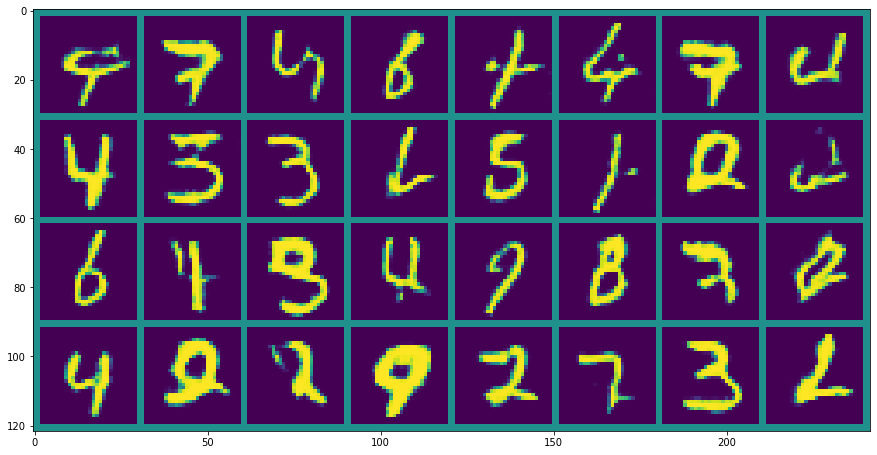

In [40]:
yet_another_iteration(7)

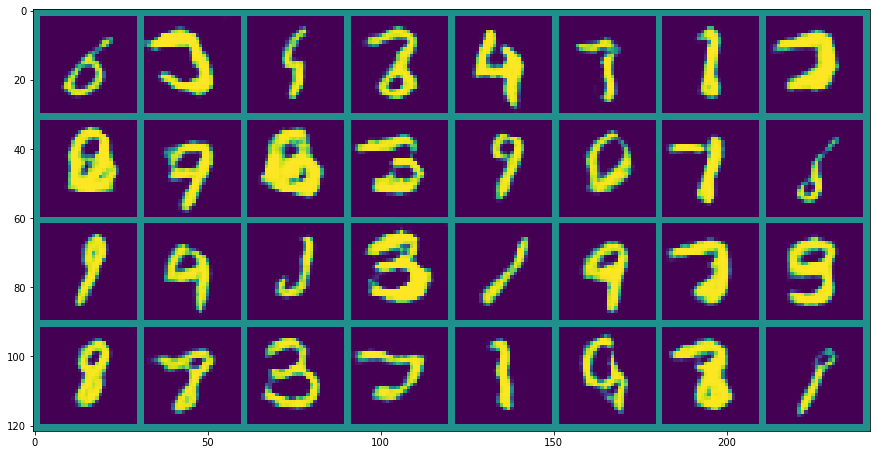

In [39]:
noise = sample_noise(256, 100).to(device)
gen_data = generator(noise)
plt.figure(figsize = (15,10))
plt.imshow(v_utils.make_grid(gen_data.data[:32]).cpu().detach().numpy()[0, :, :])

In [0]:
noise = torch.zeros(64, 100).to(device)
step = 2
for i in range(8):
  for j in range(8):
    noise[8 * i + j, 0] = i * step
    noise[8 * i + j, -1] = j * step

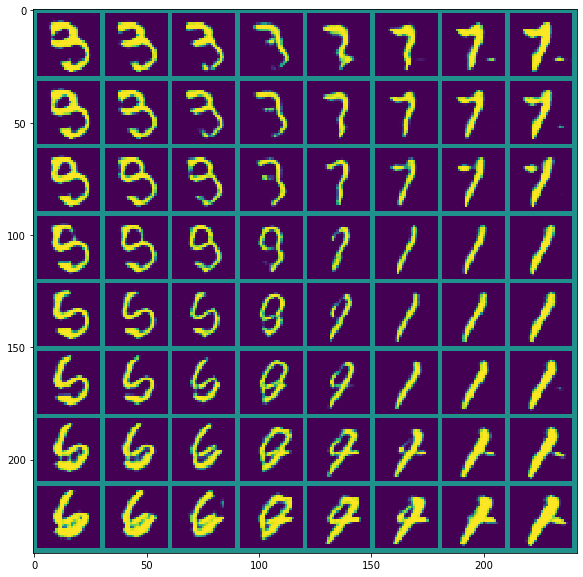

In [67]:
gen_data = generator(noise)
plt.figure(figsize = (10, 10))
plt.imshow(v_utils.make_grid(gen_data.data[:64]).cpu().detach().numpy()[0, :, :])

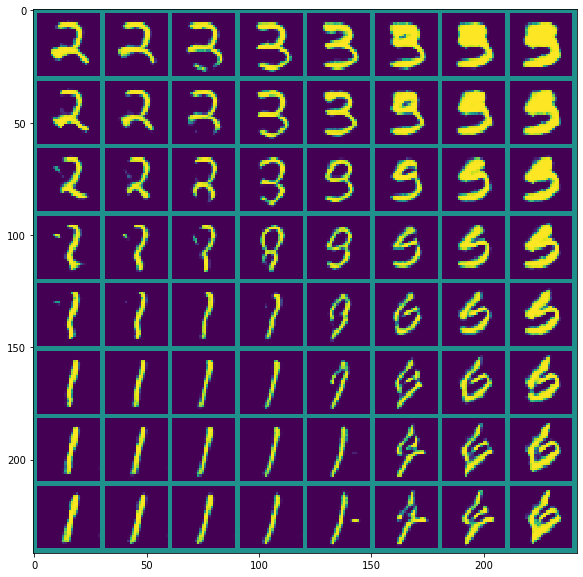

In [68]:
noise = torch.zeros(64, 100).to(device)
step = 2
for i in range(8):
  for j in range(8):
    noise[8 * i + j, 0 : 5] = i * step
    noise[8 * i + j, -5 : -1] = j * step
gen_data = generator(noise)
plt.figure(figsize = (10, 10))
plt.imshow(v_utils.make_grid(gen_data.data[:64]).cpu().detach().numpy()[0, :, :])